
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [2]:
# 元データの取得
df_age = pd.read_csv('Data/h27_age_df.csv')
df_family = pd.read_csv('Data/h27_family_df.csv')
df_gender = pd.read_csv('Data/h27_gender_df2.csv')
df_house = pd.read_csv('Data/h27_house_df.csv')
df_house_info = pd.read_csv('Data/h27_house_info_df.csv')
df_industry = pd.read_csv('Data/h27_indusry_df.csv')
df_job = pd.read_csv('Data/h27_job_df.csv')
df_labor = pd.read_csv('Data/h27_labor_df.csv')
df_marriage = pd.read_csv('Data/h27_marriage_df.csv')
df_work = pd.read_csv('Data/h27_work_status_df.csv')
df_income = pd.read_csv('Data/income_district.csv')
df_list = [df_age, df_family, df_gender, df_house, df_house_info, df_industry, df_job, df_labor, df_marriage, df_work]

## データ説明
df_listに格納されているデータの内、共通しているカラムは以下の通り.

| ヘッド名称            | データ型   | 説明                                                                                                                                                      |
|------------------|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| district_id      | int64  | state_name(都道府県)とcity_name(市区町村)を表すID, 各都道府県名には1~47の番号が, 市区町村には3桁の番号が割り振られており, 都道府県の番号と市区町村の番号が横結合されている                                                 |
| district2_id     | float  | district_name(町村)とdistrict2_name(それ以下)を表すID, district_nameとdistrict2_nameでそれぞれ別の番号が与えられており, level_identifierで1だとNan, 2だと町村のみ, 3だと全ての町村とそれ以下の番号が横結合されている |
| level_identifier | int64  | その行のデータ対象範囲を表すもの. level_identifierで1だと都道府県+市区まで, 2だと町村まで, 3だともっとも細かい区分まで見ることができる                                                                        |
| state_name       | object | 都道府県名                                                                                                                                                   |
| city_name        | object | 市区名                                                                                                                                                     |
| district_name    | object | 町村名                                                                                                                                                     |
| district2_name   | object | それ以下                                                                                                                                                    |

なお、`income_district.csv`のカラムである`area_code`は`district_id`と対応している.

このため、まずは`district_id`と都道府県＋市区名のリストを生成する.

In [3]:
# `district_id`と都道府県＋市区名のデータフレーム
pref_and_city_id = df_age[df_age["level_identifier"]==1][["district_id","state_name", "city_name"]].sort_values(by="district_id").reset_index(drop=True)
pref_and_city_id

,district_id,state_name,city_name
0,1101,北海道,札幌市中央区
1,1102,北海道,札幌市北区
2,1103,北海道,札幌市東区
3,1104,北海道,札幌市白石区
4,1105,北海道,札幌市豊平区
...,...,...,...
1891,47361,沖縄県,島尻郡久米島町
1892,47362,沖縄県,島尻郡八重瀬町
1893,47375,沖縄県,宮古郡多良間村
1894,47381,沖縄県,八重山郡竹富町


### まずはものすごく乱暴に, 全ての生データを結合させて予測させてみる

In [4]:
def df_all_reset(df_all = pref_and_city_id):
    df_all = pref_and_city_id
    for df in df_list:
        df = df[df["level_identifier"]==1]
        df = df.drop(columns=['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
        df_all = pd.merge(df_all, df, on="district_id", how="left", suffixes=('', '_df2'))
        df_all = df_all.drop(columns=[col for col in df_all.columns if col.endswith('_df2')])
    return df_all

In [5]:
def data_cleaning_0(df_all):
    df_all_only_num = df_all.drop(columns=["state_name", "city_name"])
    df_all_with_area_code = df_all_only_num.rename(columns={'district_id':'area_code'})
    df_all_with_area_code = pd.merge(df_income, df_all_with_area_code, on="area_code", how='left')
    df_all_with_area_code = df_all_with_area_code.replace({'-':0})
    df_all_with_area_code = df_all_with_area_code.dropna(axis=0)
    return df_all_with_area_code

In [6]:
#データの前処理
df_all = df_all_reset()
df_all_with_area_code = data_cleaning_0(df_all)

In [7]:
# 特徴量とターゲットを分離する
temp = df_all_with_area_code
X = temp.drop(columns=['area_code', 'income_mean'])
y = temp['income_mean']

# 訓練データとテストデータの分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
# 予測
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 評価
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

Train MSE: 1254.7912938595448
Test MSE: 2510.4618534402057
Train R2: 0.684582616916916
Test R2: 0.398506722118807


## 驚異の正答率の低さ
無理もないので、ここから必要な特徴量を生成・絞り込みを行う

## district_idの分解
都道府県番号と市区町村番号のリストをそれぞれ作成する

In [9]:
# 市区町村番号リストの作成
city_list = pd.DataFrame(pref_and_city_id[["district_id", "city_name"]])
city_list['district_id'] = city_list['district_id']%1000
city_list.rename(columns={'district_id':'city_id'}, inplace=True)

#都道府県番号リストの作成
pref_list = pd.DataFrame(pref_and_city_id[["district_id", "state_name"]])
pref_list['district_id'] = ((pref_list['district_id'] - city_list['city_id'])/1000).astype(int)
pref_list.rename(columns={'district_id':'pref_id'}, inplace=True)
pref_list.drop_duplicates(subset='pref_id', keep='first', inplace=True, ignore_index=True)
print(pref_list)

    pref_id state_name
0         1        北海道
1         2        青森県
2         3        岩手県
3         4        宮城県
4         5        秋田県
5         6        山形県
6         7        福島県
7         8        茨城県
8         9        栃木県
9        10        群馬県
10       11        埼玉県
11       12        千葉県
12       13        東京都
13       14       神奈川県
14       15        新潟県
15       16        富山県
16       17        石川県
17       18        福井県
18       19        山梨県
19       20        長野県
20       21        岐阜県
21       22        静岡県
22       23        愛知県
23       24        三重県
24       25        滋賀県
25       26        京都府
26       27        大阪府
27       28        兵庫県
28       29        奈良県
29       30       和歌山県
30       31        鳥取県
31       32        島根県
32       33        岡山県
33       34        広島県
34       35        山口県
35       36        徳島県
36       37        香川県
37       38        愛媛県
38       39        高知県
39       40        福岡県
40       41        佐賀県
41       42        長崎県
42       43

In [10]:
# df_allに新しい情報として加える
df_all = df_all_reset()
df_all = pd.merge(df_all, pref_list, on='state_name', how='left')
df_all = pd.merge(df_all, city_list, on='city_name', how='left')
print(df_all.columns)

Index(['district_id', 'state_name', 'city_name', '10-14', '15-19', '20-24',
       '25-29', '30-34', '35-39', '40-44',
       ...
       'employer_male', 'self_employed_male', 'family_work_male',
       'unkonwn_status_male', 'employer_female', 'self_employed_female',
       'family_work_female', 'unkonwn_status_female', 'pref_id', 'city_id'],
      dtype='object', length=193)


## 所得との相関
所得との相関が強いカラムについて調べる

## 年齢別人口割合との相関
`h27_age_df.csv`には、性別別・年齢別の人口に関する情報がまとめられている.
日本におけるお金を稼ぐ金額が高い人の特徴として
* 生産年齢人口の中でも半ば(25~54)
* 男性
* 子供がいる世帯

といったことが挙げられる. 先程の相関係数の算出からも, 上記特長に当てはまる場合は`income_mean`との相関係数が高いことがわかる.
よって、市区町村ごとにおける子供の人口の割合や、生産年齢人口の割合、男性の割合が収入予測に大きく役立つと考えられる.

`h27_age_df.csv`の中で, `income_mean`との相関係数が0.28を超えていたカラムは以下の通り.

| ヘッド名称          | データ型   | 説明            |
|----------------|--------|---------------|
| 0-4_male, 0-4_female | object | 0~4才の男性人口, 女性人口 |
| 5-9_male, 5-9_female | object | 5~9才の男性人口, 女性人口 |
| 20-24          | object | 20~24才の人口     |
| 25-29          | object | 25~29才の人口     |
| 30-34          | object | 30~34才の人口     |
| 35-39          | object | 35~39才の人口     |
| 40-44          | object | 40~44才の人口     |
| 45-49          | object | 45~49才の人口     |
| 50-54          | object | 50~54才の人口     |

上記のカラムの収入が高くなる原因として考えられるのは以下の通り.
1. 0-9歳児のように幼い子供がいる場合、当人が稼ぐことは無いが、育児費がかかるため
2. 男女関係なく25~49歳までの人の年収が高いのは、労働人口の主要を占めるため

このうち, 1の理由については男女差が相関に影響はしないと考えられるため, 新しい変数として生成する.

<Axes: >

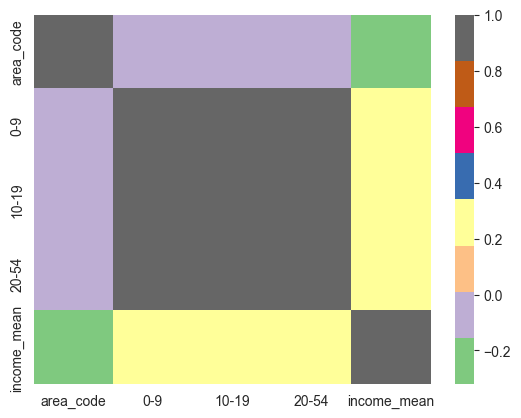

In [102]:
# 変数として使用したいカラムリスト
age_columns = ["0-4_male", "0-4_female", "5-9_male", "5-9_female","10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54"]
# df_ageのデータクレンジング
temp = df_age.replace({'-':0, 'X':0})
# 市区町村データのみ抽出
temp = temp[temp['level_identifier']==1]
# 演算に使用するデータのデータ型変更
for column in age_columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_age_for_predictを定義
df_age_for_predict = pd.concat([temp['district_id'], temp[age_columns]], axis=1)
# 幼児の割合
df_age_for_predict['0-9'] = df_age_for_predict['0-4_male'] + df_age_for_predict['0-4_female'] + df_age_for_predict['5-9_male'] + df_age_for_predict['5-9_female']
# 子供の割合
df_age_for_predict['10-19'] = df_age_for_predict['10-14'] + df_age_for_predict['15-19']
# 生産年齢人口の割合
df_age_for_predict['20-54'] = (df_age_for_predict["20-24"]+df_age_for_predict["25-29"]+df_age_for_predict["30-34"]+df_age_for_predict["35-39"]+df_age_for_predict["40-44"]
                               +df_age_for_predict["45-49"]+df_age_for_predict["50-54"])

df_age_for_predict = df_age_for_predict.drop(columns=age_columns)
df_age_for_predict = df_age_for_predict.rename(columns={'district_id':'area_code'})
df_age_for_predict_with_income = pd.merge(df_age_for_predict, df_income, on="area_code", how='left')
# df_incomeには欠損値が存在するため
df_age_for_predict.dropna(inplace=True)
df_age_for_predict.corr()
sns.heatmap(df_age_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 家族構成との相関
`h27_family_df.csv`には、各地域ごとの世帯構成に関する情報がまとめられている.
先程の相関係数の算出から, 日本における収入が高い世帯の特徴として
* 3~5人家族世帯

において、収入との高い相関がみられた.
よって、市区町村ごとにおける3~5人世帯割合が収入予測に大きく役立つと考えられる.

`h27_family_df.csv`の中で, 特徴的なカラムは以下の通り.

| ヘッド名称        | データ型   | 説明      |
|--------------|--------|---------|
| family_count | object | 世帯数     |
| member_3     | object | 3人家族世帯数 |
| member_4     | object | 4人家族世帯数 |
| member_5     | object | 5人家族世帯数 |

全世帯数の内、3~5人家族世帯の割合が高いほど、その地域の収入平均が高くなることが予想されるため、新しい変数として生成する.

<Axes: >

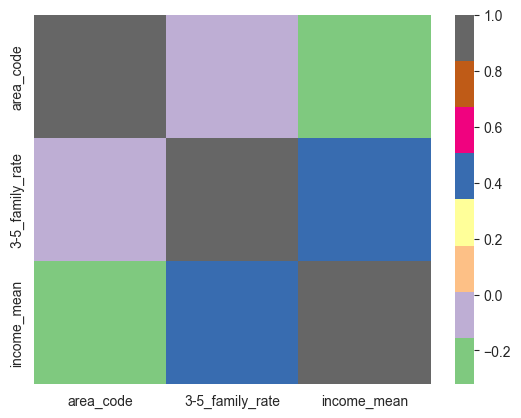

In [103]:
# 変数として使用したいカラムリスト
family_columns = ["family_count", "member_3", "member_4", "member_5"]
# df_familyのデータクレンジング
temp = df_family.replace({'-':0, 'X':0})
# 市区町村データのみ抽出
temp = temp[temp['level_identifier']==1]
# 演算に使用するデータのデータ型変更
for column in family_columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_age_for_predictを定義
df_family_for_predict = pd.concat([temp['district_id'], temp[family_columns]], axis=1)
# 3~5人世帯の数
medium_family_num = temp['member_3'] + temp['member_4'] + temp['member_5']
# 3~5人世帯の割合
df_family_for_predict['3-5_family_rate'] = medium_family_num/df_family_for_predict['family_count']

df_family_for_predict = df_family_for_predict.drop(columns=family_columns)
df_family_for_predict = df_family_for_predict.rename(columns={'district_id':'area_code'})
df_family_for_predict_with_income = pd.merge(df_family_for_predict, df_income, on="area_code", how='left')
# df_incomeには欠損値が存在するため
df_family_for_predict.dropna(inplace=True)
df_family_for_predict.corr()
sns.heatmap(df_family_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 住宅所持との相関
`h27_house_df.csv`には、各地域ごとの世帯ごとの住宅に関する情報がまとめられている.
先程の相関係数の算出から, 日本における収入が高い世帯の特徴として
* `own_house`, `salaly_rent`,`other_house`の世帯

において、収入との高い相関がみられた. これは家族世帯であろうと、単身世帯であろうと同じ傾向であった.
よって、市区町村ごとにおける`own_house`, `salaly_rent`,`other_house`の住宅割合が収入予測に大きく役立つと考えられる.

`h27_house_df.csv`の中で, 特徴的なカラムは以下の通り.

| ヘッド名称                  | データ型   | 説明               |
|------------------------|--------|------------------|
| family_house           | object | 家族を持つ世帯数         |
| own_house_family       | object | 持ち家を持つ家族世帯数      |
| salaly_rent_family     | object | 会社所有の持ち家を持つ家族世帯数 |
| other_house_family     | object | その他の家の種類を持つ家族世帯数 |
| own_house_individual   | object | 持ち家を持つ単身世帯数      |
| salaly_rent_individual | object | 会社所有の持ち家を持つ単身世帯数 |
| other_house_individual | object | その他の家の種類を持つ単身世帯数 |

全世帯数の内、`own_house`, `salaly_rent`,`other_house`の住宅割合が高いほど、その地域の収入平均が高くなることが予想されるため、新しい変数として生成する.

<Axes: >

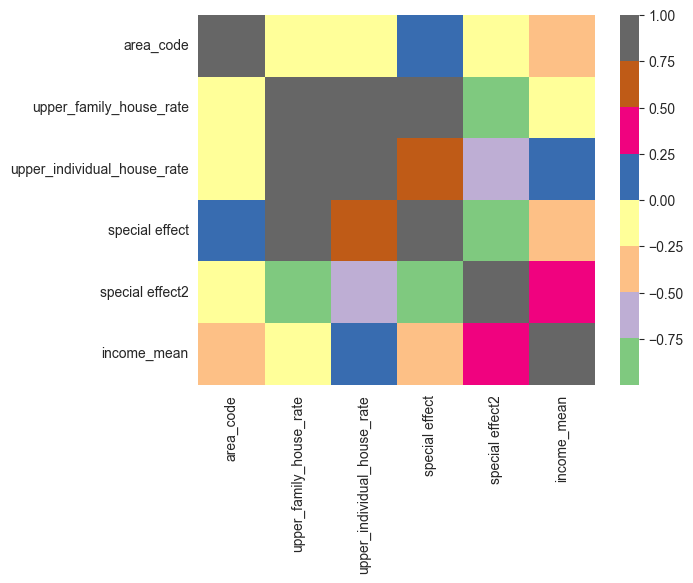

In [106]:
# 変数として使用したいカラムリスト
house_columns = ['family_house', 'own_house_family','salary_rent_family', 'room_rent_family', 'other_house_family','own_house_individual', 'public_rent_individual',
                  'private_rent_individual', 'salary_rent_individual','room_rent_individual', 'other_house_individual']
individual_columns = ['own_house_individual', 'public_rent_individual', 'private_rent_individual', 'salary_rent_individual','room_rent_individual', 'other_house_individual']
# df_familyのデータクレンジング
temp = df_house.replace({'-':0, 'X':0})
# 市区町村データのみ抽出
temp = temp[temp['level_identifier']==1]
# 演算に使用するデータのデータ型変更
for column in house_columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_age_for_predictを定義
df_house_for_predict = pd.concat([temp['district_id'], temp[house_columns]], axis=1)
# 家族世帯における、高い収入傾向のある住宅所持者の数
upper_family_house_num = temp['own_house_family'] + temp['salary_rent_family'] + temp['other_house_family']
# 家族世帯における、高い収入傾向のある住宅所持者の割合
df_house_for_predict['upper_family_house_rate'] = upper_family_house_num/temp['family_house']

#単身世帯における、高い収入傾向のある住宅所持者の数
upper_individual_house_num = temp['own_house_individual'] + temp['salary_rent_individual'] + temp['other_house_individual']
# 単身世帯における、高い収入傾向のある住宅所持者の割合
df_house_for_predict['upper_individual_house_rate'] = upper_individual_house_num/(temp[individual_columns].sum(axis=1))

# 相乗効果ってあるのかな？
df_house_for_predict['special effect'] = df_house_for_predict['upper_family_house_rate']/df_house_for_predict['upper_individual_house_rate']
df_house_for_predict['special effect2'] = df_house_for_predict['upper_individual_house_rate']/df_house_for_predict['upper_family_house_rate']

df_house_for_predict = df_house_for_predict.drop(columns=house_columns)
df_house_for_predict = df_house_for_predict.rename(columns={'district_id':'area_code'})
df_house_for_predict_with_income = pd.merge(df_house_for_predict, df_income, on="area_code", how='left')
#df_incomeには欠損値が存在するため
df_house_for_predict.dropna(inplace=True)
df_house_for_predict.corr()
sns.heatmap(df_house_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 住宅情報との相関
`h27_house_info_df.csv`には、各地域ごとの世帯ごとの住宅に関する情報がまとめられている.

In [92]:
df_house_info_temp = df_house_info[df_house_info['level_identifier']==1]
df_house_info_temp = df_house_info_temp.drop(columns=['district2_id', 'level_identifier','state_name', 'city_name', 'district_name', 'district2_name'])
df_house_info_temp = df_house_info_temp.rename(columns={'district_id':'area_code'})
df_house_info_temp = df_house_info_temp.replace({'-':0, 'X':0})
temp = pd.merge(df_income, df_house_info_temp, on='area_code', how='left')
# 住宅情報と収入に相関があるグループ
middle_house_info = temp.corr()[temp.corr()['income_mean'].abs()>0.23]
# 家族世帯と単身世帯で分ける
family_house_columns = ["family" in s for s in middle_house_info]
family_house_info = pd.concat([temp.loc[:,family_house_columns], temp['area_code']], axis=1)
individual_house_columns = ["individual" in s for s in middle_house_info]
individual_house_info = pd.concat([temp.loc[:,individual_house_columns], temp['area_code']], axis=1)
print('middle_house_info:')
family_house_info.dtypes

middle_house_info:


single_house_family    object
long_house_family      object
share_house_family     object
1-2floor_family        object
3-5floor_family        object
6-10floor_family       object
11floor_family         object
area_code               int64
dtype: object

上記のようにデータについて調べてみると、日本における世帯別住宅情報の特徴として
* 家族世帯では、以下の住宅に住んでいる場合収入が高い傾向にある
    * 'share_house_family', '1-2floor_family', '3-5floor_family'
* 単身世帯では、以下の住宅に住んでいる場合収入が高い傾向にある
    * 'share_house_individual', '1-2floor_individual', '3-5floor_individual','6-10floor_individual'

これらの高い収入傾向がある住宅に住んでいる人の割合について、家族世帯/単身世帯でそれぞれの割合を出すことで、新しい説明変数を生成する.

Index(['family_count', 'single_house_family', 'long_house_family',
       'share_house_family', '1-2floor_family', '3-5floor_family',
       '6-10floor_family', '11floor_family', 'family_work_male',
       'family_work_female', '3-5_family_rate', 'upper_family_house_rate'],
      dtype='object')


<Axes: >

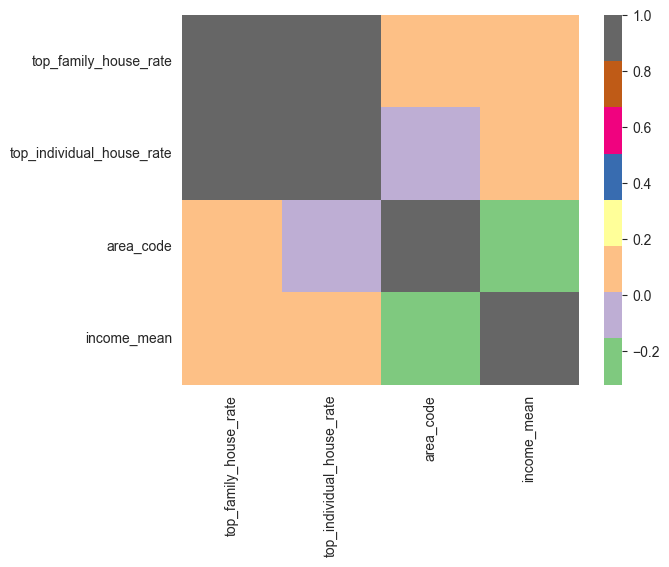

In [139]:
# データクレンジング
#print(family_house_info.dtypes)
# 演算に使用するデータのデータ型変更
family_house_info = family_house_info.fillna(0)
family_house_info = family_house_info.astype(int)
individual_house_info = individual_house_info.fillna(0)
individual_house_info = individual_house_info.astype(int)
temp = temp.fillna(0)
temp = temp.astype(int)


# 重要そうな変数だけ格納されているdf_house_info_for_predictを定義
df_house_info_for_predict = pd.concat([family_house_info, individual_house_info], axis=1)
# 収入傾向と高い相関関係にある住宅を持つ家族世帯数
top_family_house_num = family_house_info.sum(axis=1) 
# 収入傾向と高い相関関係にある住宅を持つ家族世帯割合
family_house_columns = temp.filter(like='family').columns
print(family_house_columns)
df_house_info_for_predict['top_family_house_rate'] = top_family_house_num/temp[family_house_columns].sum(axis=1)
# 収入傾向と高い相関関係にある住宅を持つ単身世帯数
top_individual_house_num = individual_house_info.sum(axis=1) 
# 収入傾向と高い相関関係にある住宅を持つ単身世帯割合
individual_house_columns = temp.filter(like='individual').columns
df_house_info_for_predict['top_individual_house_rate'] = top_individual_house_num/temp[individual_house_columns].sum(axis=1)

# 相乗効果ってあるのかな？
#df_house_for_predict['special effect'] = df_house_for_predict['upper_family_house_rate']/df_house_for_predict['upper_individual_house_rate']
#df_house_for_predict['special effect2'] = df_house_for_predict['upper_individual_house_rate']/df_house_for_predict['upper_family_house_rate']

df_house_info_for_predict = df_house_info_for_predict[['top_family_house_rate', 'top_individual_house_rate']]
df_house_info_for_predict_with_income = pd.concat([df_house_info_for_predict, df_income],axis=1)

#df_incomeには欠損値が存在するため
df_house_info_for_predict.dropna(inplace=True)
df_house_info_for_predict.corr()
sns.heatmap(df_house_info_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 産業別割合との相関
`h27_indusry_df.csv`には、産業別・性別ごとの就業人口に関する情報がまとめられている.

In [16]:
df_industry_temp = df_industry[df_industry['level_identifier']==1]
df_industry_temp = df_industry_temp.drop(columns=['district2_id', 'level_identifier','state_name', 'city_name', 'district_name', 'district2_name'])
df_industry_temp = df_industry_temp.rename(columns={'district_id':'area_code'})
df_industry_temp = df_industry_temp.replace({'-':0, 'X':0})
temp = pd.merge(df_income, df_industry_temp, on='area_code', how='left')
# 産業と収入に強い相関があるグループ
top_occupation = temp.corr()[temp.corr()['income_mean'].abs()>0.29]
# 産業と収入にそれなりに相関があるグループ
middle_occupation = temp.corr()[(0.25 < temp.corr()['income_mean'].abs()) &(temp.corr()['income_mean'].abs() < 0.29)]
# 産業と収入にそれなりに相関があるグループ
low_occupation = temp.corr()[temp.corr()['income_mean']<-0.1]
print('top_ocuppation:')
print(top_occupation.index[2::])
print('middle_ocuppation:')
print(middle_occupation.index[2::])
print('low_occupation:')
print(low_occupation.index[2::])

top_ocuppation:
Index(['E_manufacturing_male', 'G_information_male', 'J_Finance_male',
       'K_real_estate_male', 'L_academic_male', 'E_manufacturing_female',
       'G_information_female', 'H_transport_female', 'J_Finance_female',
       'K_real_estate_female', 'L_academic_female', 'O_education_female'],
      dtype='object')
middle_ocuppation:
Index(['N_entertainment_male', 'O_education_male', 'R_other_service_male',
       'F_Electricity_female', 'I_wholesale_female', 'N_entertainment_female',
       'R_other_service_female'],
      dtype='object')
low_occupation:
Index(['agriculture_male', 'B_fishing_male', 'A_agriculture_forestry_female',
       'agriculture_female', 'B_fishing_female'],
      dtype='object')


上記のようにデータについて調べてみると、日本における産業別の特徴として
* 以下の産業では、収入と強い相関がある
    * 'E_manufacturing_male', 'G_information_male', 'J_Finance_male', 'K_real_estate_male', 'L_academic_male', 'E_manufacturing_female', 'G_information_female', 'H_transport_female', 'J_Finance_female', 'K_real_estate_female', 'L_academic_female', 'O_education_female'
* 以下の産業では、収入とそこそこ相関がある
    * 'N_entertainment_male', 'O_education_male', 'R_other_service_male', 'F_Electricity_female', 'I_wholesale_female', 'N_entertainment_female', 'R_other_service_female'

といったことが挙げられる. 先程の相関係数の算出からも, 上記産業においては`income_mean`との相関係数が高いことがわかる.
よって、市区町村ごとにおける産業別割合が収入予測に大きく役立つと考えられる.

強い相関がみられていた産業、及びそこそこ相関がみられていた産業それぞれの割合を出すことで、新しい説明変数を生成する.

<Axes: >

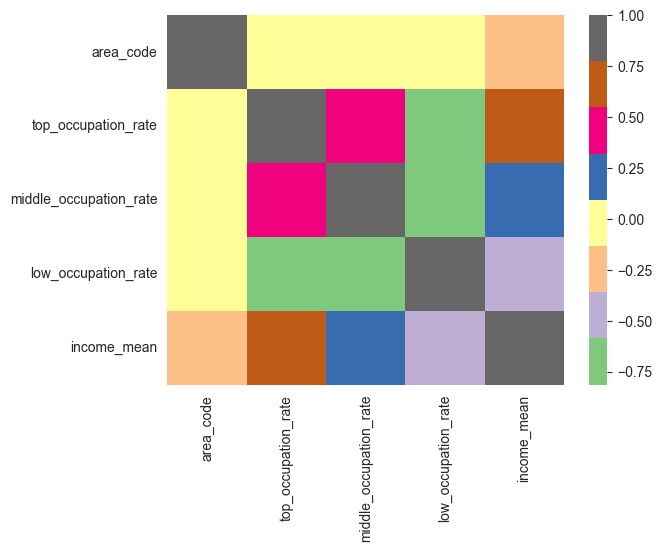

In [108]:
# df_industryのデータクレンジング
temp = df_industry_temp.replace({'-':0, 'X':0})
# 演算に使用するデータのデータ型変更
for column in temp.drop(columns="area_code").columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_industry_for_predictを定義
df_industry_for_predict = pd.concat([temp['area_code'], temp[top_occupation.index[2::]], temp[middle_occupation.index[2::]], temp[low_occupation.index[2::]]], axis=1)
# 収入傾向と高い相関関係にある産業の就業人数
top_occupation_num = temp[top_occupation.index[2::]].sum(axis=1) 
# 収入傾向と高い相関関係にある産業の就業人数の割合
df_industry_for_predict['top_occupation_rate'] = top_occupation_num/temp.drop(columns="area_code").sum(axis=1)
# 収入傾向とそこそこ高い相関関係にある産業の就業人数
middle_occupation_num = temp[middle_occupation.index[2::]].sum(axis=1) 
# 収入傾向とそこそこ高い相関関係にある産業の就業人数の割合
df_industry_for_predict['middle_occupation_rate'] = middle_occupation_num/temp.drop(columns="area_code").sum(axis=1)
# 収入傾向とそこそこ高い相関関係にある産業の就業人数
low_occupation_num = temp[low_occupation.index[2::]].sum(axis=1) 
# 収入傾向とそこそこ高い相関関係にある産業の就業人数の割合
df_industry_for_predict['low_occupation_rate'] = low_occupation_num/temp.drop(columns="area_code").sum(axis=1)

# 相乗効果ってあるのかな？
#df_house_for_predict['special effect'] = df_house_for_predict['upper_family_house_rate']/df_house_for_predict['upper_individual_house_rate']
#df_house_for_predict['special effect2'] = df_house_for_predict['upper_individual_house_rate']/df_house_for_predict['upper_family_house_rate']

df_industry_for_predict = df_industry_for_predict.drop(columns=top_occupation.index[2::])
df_industry_for_predict = df_industry_for_predict.drop(columns=middle_occupation.index[2::])
df_industry_for_predict = df_industry_for_predict.drop(columns=low_occupation.index[2::])
df_industry_for_predict = df_industry_for_predict.rename(columns={'district_id':'area_code'})
df_industry_for_predict_with_income = pd.merge(df_industry_for_predict, df_income, on="area_code", how='left')
#df_incomeには欠損値が存在するため
df_industry_for_predict.dropna(inplace=True)
df_industry_for_predict.corr()
sns.heatmap(df_industry_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 職階との相関
`df_job.csv`には、職階・性別ごとの就業人口に関する情報がまとめられている.

In [18]:
df_job_temp = df_job[df_job['level_identifier']==1]
df_job_temp = df_job_temp.drop(columns=['district2_id', 'level_identifier','state_name', 'city_name', 'district_name', 'district2_name'])
df_job_temp = df_job_temp.rename(columns={'district_id':'area_code'})
df_job_temp = df_job_temp.replace({'-':0, 'X':0})
temp = pd.merge(df_income, df_job_temp, on='area_code', how='left')
# 職階と収入に強い相関があるグループ
top_job = temp.corr()[temp.corr()['income_mean'].abs()>0.29]
# 職階と収入にそれなりに相関があるグループ
middle_job = temp.corr()[(0.25 < temp.corr()['income_mean'].abs()) &(temp.corr()['income_mean'].abs() < 0.29)]

print('top_job:')
print(top_job.index[2::])
print('middle_job:')
print(middle_job.index[2::])


top_job:
Index(['A_administrative_male', 'B_professional_workers_male',
       'C_office_workers_male', 'D_sales_workers_male',
       'C_office_workers_female'],
      dtype='object')
middle_job:
Index(['B_professional_workers_female', 'D_sales_workers_female',
       'I_transport_workers_female'],
      dtype='object')


上記のようにデータについて調べてみると、日本における職種別の特徴として
* 以下の職種では、収入と強い相関がある
    * 'A_administrative_male', 'B_professional_workers_male', 'C_office_workers_male', 'D_sales_workers_male', 'C_office_workers_female'
* 以下の職種では、収入とそこそこ相関がある
    * 'B_professional_workers_female', 'D_sales_workers_female', 'I_transport_workers_female'

といったことが挙げられる. 先程の相関係数の算出からも, 上記職種においては`income_mean`との相関係数が高いことがわかる.
よって、市区町村ごとにおける職種別割合が収入予測に大きく役立つと考えられる.

強い相関がみられていた産業、及びそこそこ相関がみられていた職種それぞれの割合を出すことで、新しい説明変数を生成する.

<Axes: >

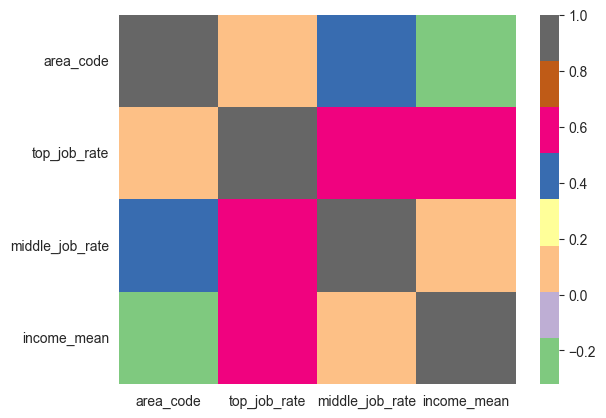

In [109]:
# df_jobのデータクレンジング
temp = df_job_temp.replace({'-':0, 'X':0})
# 演算に使用するデータのデータ型変更
for column in temp.drop(columns="area_code").columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_job_for_predictを定義
df_job_for_predict = pd.concat([temp['area_code'], temp[top_job.index[2::]], temp[middle_job.index[2::]]], axis=1)
# 収入傾向と高い相関関係にある産業の就業人数
top_job_num = temp[top_job.index[2::]].sum(axis=1) 
# 収入傾向と高い相関関係にある産業の就業人数の割合
df_job_for_predict['top_job_rate'] = top_job_num/temp.drop(columns="area_code").sum(axis=1)
# 収入傾向とそこそこ高い相関関係にある産業の就業人数
middle_job_num = temp[middle_job.index[2::]].sum(axis=1) 
# 収入傾向とそこそこ高い相関関係にある産業の就業人数の割合
df_job_for_predict['middle_job_rate'] = middle_job_num/temp.drop(columns="area_code").sum(axis=1)

df_job_for_predict = df_job_for_predict.drop(columns=top_job.index[2::])
df_job_for_predict = df_job_for_predict.drop(columns=middle_job.index[2::])
df_job_for_predict = df_job_for_predict.rename(columns={'district_id':'area_code'})
df_job_for_predict_with_income = pd.merge(df_job_for_predict, df_income, on="area_code", how='left')
#df_incomeには欠損値が存在するため
df_job_for_predict.dropna(inplace=True)
df_job_for_predict.corr()
sns.heatmap(df_job_for_predict_with_income.corr(), cbar="True", cmap='Accent')

## 結婚との相関
`h27_marriage_df.csv`には、地域ごとの結婚/離婚の有無に関する情報がまとめられている.
先程の相関係数の算出から, 日本における収入が高い世帯の特徴として
* 離婚していない男性
* 結婚している女性

が挙げられる。
よって、地域ごとの各割合が高いほど、その地域の収入平均が高くなることが予想されるため、新しい変数として生成する.

`h27_marriage_df.csv`の中で, 特徴的なカラムは以下の通り.

| ヘッド名称        | データ型   | 説明      |
|--------------|--------|---------|
| married_male | object | 既婚男性の人数 |
| unmarried_male     | object | 未婚男性の人数 |
| divorced_male     | object | 離婚男性の人数 |
| married_female     | object | 既婚女性の人数 |
| unmarried_female     | object | 未婚女性の人数 |
| divorced_female     | object | 離婚女性の人数 |


<Axes: >

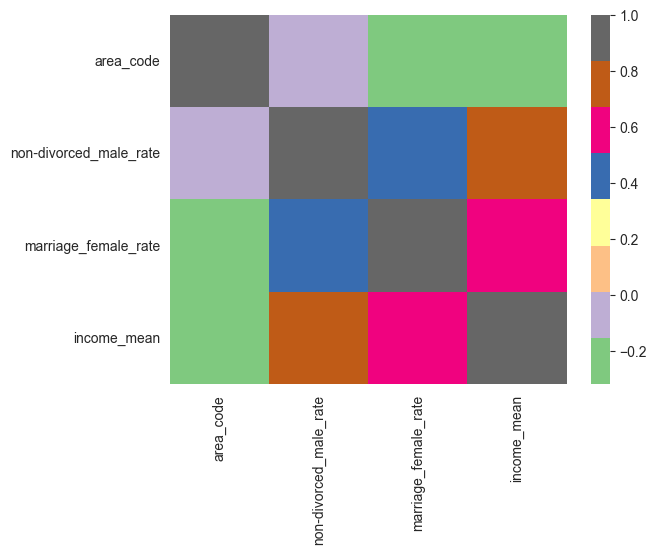

In [110]:
# 変数として使用したいカラムリスト
marriage_columns = ["married_male", "unmarried_male", "divorced_male", "married_female", "unmarried_female", "divorced_female"]
# df_familyのデータクレンジング
temp = df_marriage.replace({'-':0, 'X':0})
# 市区町村データのみ抽出
temp = temp[temp['level_identifier']==1]
# 演算に使用するデータのデータ型変更
for column in marriage_columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_age_for_predictを定義
df_marriage_for_predict = pd.concat([temp['district_id'], temp[marriage_columns]], axis=1)
# 離婚していない男性の割合
df_marriage_for_predict['non-divorced_male_rate'] = 1 - temp['divorced_male']/(temp['married_male']+temp['unmarried_male']+temp['divorced_male'])
# 結婚している女性の割合
df_marriage_for_predict['marriage_female_rate'] = temp['married_female']/(temp['married_female']+temp['unmarried_female']+temp['divorced_female'])

df_marriage_for_predict = df_marriage_for_predict.drop(columns=marriage_columns)
df_marriage_for_predict = df_marriage_for_predict.rename(columns={'district_id':'area_code'})
df_marriage_for_predict_with_income = pd.merge(df_marriage_for_predict, df_income, on="area_code", how='left')
# df_incomeには欠損値が存在するため
df_marriage_for_predict.dropna(inplace=True)
df_marriage_for_predict.corr()
sns.heatmap(df_marriage_for_predict_with_income.corr(), cbar="True", cmap='Accent')

# 就業の有無との相関
`h27_labor_df.csv`には、地域・性別ごとの就業の有無に関する情報がまとめられている.
先程の相関係数の算出から, 日本における収入が高い人の特徴には「就業していること」が挙げられる.
よって、地域ごとの就業割合が高いほど、その地域の収入平均が高くなることが予想されるため、新しい変数として生成する.

`h27_labor_df.csv`の中で, 特徴的なカラムは以下の通り.

| ヘッド名称        | データ型   | 説明      |
|--------------|--------|---------|
| labor_male | object | 就業している男性の人数 |
| no_labor_male     | object | 就業していない男性の人数 |
| labor_female | object | 就業している女性の人数 |
| no_labor_female     | object | 就業していない女性の人数 |

<Axes: >

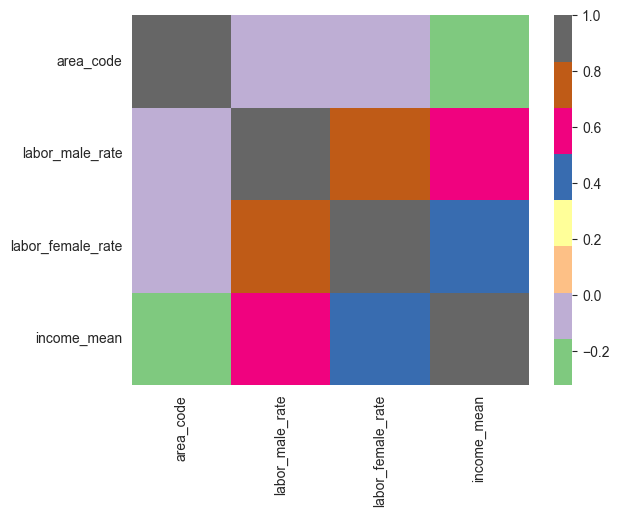

In [111]:
# 変数として使用したいカラムリスト
labor_columns = ["labor_male", "no_labor_male", "labor_female","no_labor_female"]
# df_familyのデータクレンジング
temp = df_labor.replace({'-':0, 'X':0})
# 市区町村データのみ抽出
temp = temp[temp['level_identifier']==1]
# 演算に使用するデータのデータ型変更
for column in labor_columns:
    temp = temp.astype({column:int})
# 重要そうな変数だけ格納されているdf_age_for_predictを定義
df_labor_for_predict = pd.concat([temp['district_id'], temp[labor_columns]], axis=1)
# 就業している男性の割合
df_labor_for_predict['labor_male_rate'] = temp['labor_male']/(temp['labor_male']+temp['no_labor_male'])
# 就業している女性の割合
df_labor_for_predict['labor_female_rate'] = temp['labor_female']/(temp['labor_female']+temp['no_labor_female'])

df_labor_for_predict = df_labor_for_predict.drop(columns=labor_columns)
df_labor_for_predict = df_labor_for_predict.rename(columns={'district_id':'area_code'})
df_labor_for_predict_with_income = pd.merge(df_labor_for_predict, df_income, on="area_code", how='left')
# df_incomeには欠損値が存在するため
df_labor_for_predict.dropna(inplace=True)
df_labor_for_predict.corr()
sns.heatmap(df_labor_for_predict_with_income.corr(), cbar="True", cmap='Accent')

In [141]:
df_list = [df_gender, df_house_info, df_work]


#データの前処理
df_all = df_all_reset()
df_all_with_area_code = data_cleaning_0(df_all)
#作成したデータの挿入
df_all_with_area_code = pd.merge(df_all_with_area_code, df_age_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_family_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_house_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_industry_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_job_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_marriage_for_predict, on="area_code", how='left')
df_all_with_area_code = pd.merge(df_all_with_area_code, df_labor_for_predict, on="area_code", how='left')
#df_all_with_area_code = pd.merge(df_all_with_area_code, df_house_info_for_predict, on="area_code", how='left') できませんでした
# 特徴量とターゲットを分離する
temp = df_all_with_area_code
X = temp.drop(columns=['area_code', 'income_mean'])
y = temp['income_mean']

# 訓練データとテストデータの分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 標準化
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Train MSE: 541.0213454078871
Test MSE: 701.8210481786157
Train R2: 0.8646535659015867
Test R2: 0.8284684765689231


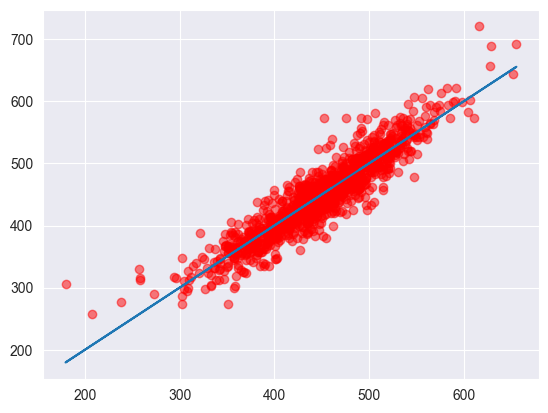

In [142]:
# 予測
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 評価
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

#グラフ上での表示
graph_x = model.predict(X)
graph_y = y
plt.scatter(graph_x, graph_y, c="red", marker="o", alpha=0.5)
plt.plot(graph_x, graph_x)
plt.show()


In [57]:
df_all_with_area_code.corr()["income_mean"]

area_code                     -0.320149
income_mean                    1.000000
population                     0.264002
male_population                0.274019
female_population              0.254056
family_count                   0.247590
single_house_family            0.188916
long_house_family              0.025823
share_house_family             0.255131
1-2floor_family                0.245965
3-5floor_family                0.231213
6-10floor_family               0.225931
11floor_family                 0.205282
single_house_individual        0.222328
long_house_individual          0.067042
share_house_individual         0.269131
1-2floor_individual            0.240078
3-5floor_individual            0.243124
6-10floor_individual           0.254222
11floor_individual             0.219984
employer_male                  0.310620
self_employed_male             0.162484
family_work_male               0.035950
unkonwn_status_male            0.226918
employer_female                0.272825


## 家族構成との相関
`h27_family_df.csv`には、各地域ごとの世帯構成に関する情報がまとめられている.
先程の相関係数の算出から, 日本における収入が高い世帯の特徴として
* 3~5人家族世帯

において、収入との高い相関がみられた.
よって、市区町村ごとにおける3~5人世帯割合が収入予測に大きく役立つと考えられる.

`h27_family_df.csv`の中で, 特徴的なカラムは以下の通り.

| ヘッド名称        | データ型   | 説明      |
|--------------|--------|---------|
| family_count | object | 世帯数     |
| member_3     | object | 3人家族世帯数 |
| member_4     | object | 4人家族世帯数 |
| member_5     | object | 5人家族世帯数 |

全世帯数の内、3~5人家族世帯の割合が高いほど、その地域の収入平均が高くなることが予想されるため、新しい変数として生成する.